# Generative Adversarial Network
Architecture for this model was inspired by Gonçalo Chambel's Medium article on using a DCGAN to generate Pokémons 
## Imports and constants

In [1]:
import os
import re
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import preprocessing
from keras.models import Sequential
from keras.layers import Input, Conv2D, Dense, Flatten, BatchNormalization, LeakyReLU, ReLU, Reshape, Conv2DTranspose
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.losses import BinaryCrossentropy

tf.keras.utils.set_random_seed(1)

latent_dim = 100
image_size = 128
batch_size = 32
dataset_folder = "dataset"
trained_models_folder = "trained_models"
generated_images_folder = "generated_images"

gen_optimizer = disc_optimizer = Adam(0.0002, 0.5)
binary_cross_entropy = tf.keras.losses.BinaryCrossentropy()

2024-04-07 08:09:55.249829: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-07 08:09:55.299106: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-07 08:09:55.299140: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-07 08:09:55.300388: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-07 08:09:55.309442: I tensorflow/core/platform/cpu_feature_guar

## Additional augmentation

In [2]:
def DiffAugment(x, policy='', channels_first=False):
    if policy:
        if channels_first:
            x = tf.transpose(x, [0, 2, 3, 1])
        for p in policy.split(','):
            for f in AUGMENT_FNS[p]:
                x = f(x)
        if channels_first:
            x = tf.transpose(x, [0, 3, 1, 2])
    return x


def rand_brightness(x):
    magnitude = tf.random.uniform([tf.shape(x)[0], 1, 1, 1]) - 0.5
    x = x + magnitude
    return x


def rand_saturation(x):
    magnitude = tf.random.uniform([tf.shape(x)[0], 1, 1, 1]) * 2
    x_mean = tf.reduce_mean(x, axis=3, keepdims=True)
    x = (x - x_mean) * magnitude + x_mean
    return x


def rand_contrast(x):
    magnitude = tf.random.uniform([tf.shape(x)[0], 1, 1, 1]) + 0.5
    x_mean = tf.reduce_mean(x, axis=[1, 2, 3], keepdims=True)
    x = (x - x_mean) * magnitude + x_mean
    return x


def rand_translation(x, ratio=0.125):
    batch_size = tf.shape(x)[0]
    image_size = tf.shape(x)[1:3]
    shift = tf.cast(tf.cast(image_size, tf.float32) * ratio + 0.5, tf.int32)
    translation_x = tf.random.uniform([batch_size, 1], -shift[0], shift[0] + 1, dtype=tf.int32)
    translation_y = tf.random.uniform([batch_size, 1], -shift[1], shift[1] + 1, dtype=tf.int32)
    grid_x = tf.clip_by_value(tf.expand_dims(tf.range(image_size[0], dtype=tf.int32), 0) + translation_x + 1, 0,
                              image_size[0] + 1)
    grid_y = tf.clip_by_value(tf.expand_dims(tf.range(image_size[1], dtype=tf.int32), 0) + translation_y + 1, 0,
                              image_size[1] + 1)
    x = tf.gather_nd(tf.pad(x, [[0, 0], [1, 1], [0, 0], [0, 0]]), tf.expand_dims(grid_x, -1), batch_dims=1)
    x = tf.transpose(tf.gather_nd(tf.pad(tf.transpose(x, [0, 2, 1, 3]), [[0, 0], [1, 1], [0, 0], [0, 0]]),
                                  tf.expand_dims(grid_y, -1), batch_dims=1), [0, 2, 1, 3])
    return x


def rand_cutout(x, ratio=0.5):
    batch_size = tf.shape(x)[0]
    image_size = tf.shape(x)[1:3]
    cutout_size = tf.cast(tf.cast(image_size, tf.float32) * ratio + 0.5, tf.int32)
    offset_x = tf.random.uniform([tf.shape(x)[0], 1, 1], maxval=image_size[0] + (1 - cutout_size[0] % 2),
                                 dtype=tf.int32)
    offset_y = tf.random.uniform([tf.shape(x)[0], 1, 1], maxval=image_size[1] + (1 - cutout_size[1] % 2),
                                 dtype=tf.int32)
    grid_batch, grid_x, grid_y = tf.meshgrid(tf.range(batch_size, dtype=tf.int32),
                                             tf.range(cutout_size[0], dtype=tf.int32),
                                             tf.range(cutout_size[1], dtype=tf.int32), indexing='ij')
    cutout_grid = tf.stack(
        [grid_batch, grid_x + offset_x - cutout_size[0] // 2, grid_y + offset_y - cutout_size[1] // 2], axis=-1)
    mask_shape = tf.stack([batch_size, image_size[0], image_size[1]])
    cutout_grid = tf.maximum(cutout_grid, 0)
    cutout_grid = tf.minimum(cutout_grid, tf.reshape(mask_shape - 1, [1, 1, 1, 3]))
    mask = tf.maximum(
        1 - tf.scatter_nd(cutout_grid, tf.ones([batch_size, cutout_size[0], cutout_size[1]], dtype=tf.float32),
                          mask_shape), 0)
    x = x * tf.expand_dims(mask, axis=3)
    return x


AUGMENT_FNS = {
    'color': [rand_brightness, rand_saturation, rand_contrast],
    'translation': [rand_translation],
    'cutout': [rand_cutout],
}

## Load dataset

In [3]:
def get_dataset(folder, image_size, batch_size):
    ds = tf.keras.utils.image_dataset_from_directory(
        f'{os.getcwd()}/{folder}',
        image_size=(image_size, image_size),
        labels='inferred',
        batch_size=1,
    )
    
    def transform_data(image, label):
        return (image[0] - 127.5) / 127.5
    
    ds = ds.map(transform_data)
    ds = ds.batch(batch_size)
    
    return ds

## Generate images

In [4]:
def generate_and_save_images(model, epoch, seed):
    generated_images = model(seed)
    plt.figure(figsize=(5, 5))
    for i in range(generated_images.shape[0]):
        plt.subplot(5, 5, i+1)
        img = preprocessing.image.array_to_img((generated_images[i] + 1 / 2))
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()
    plt.savefig(f'{generated_images_folder}/generated_image_epoch_{epoch}.png')
    plt.close()

## Generator architecture

In [5]:
initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

generator = Sequential([
    Input(shape=(latent_dim,)),

    Dense(8 * 8 * 1024),
    Reshape((8, 8, 1024)),

    Conv2DTranspose(512, kernel_size=(5, 5), strides=(2, 2), padding='same', kernel_initializer=initializer, use_bias=False),
    BatchNormalization(momentum=0.1, epsilon=0.8, center=1.0, scale=0.02),
    ReLU(),

    Conv2DTranspose(256, kernel_size=(5, 5), strides=(2, 2), padding='same', kernel_initializer=initializer, use_bias=False),
    BatchNormalization(momentum=0.1, epsilon=0.8, center=1.0, scale=0.02),
    ReLU(),

    Conv2DTranspose(128, kernel_size=(5, 5), strides=(2, 2), padding='same', kernel_initializer=initializer, use_bias=False),
    BatchNormalization(momentum=0.1, epsilon=0.8, center=1.0, scale=0.02),
    ReLU(),

    Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', kernel_initializer=initializer, use_bias=False),
    BatchNormalization(momentum=0.1, epsilon=0.8, center=1.0, scale=0.02),
    ReLU(),

    Conv2D(3, kernel_size=(5, 5), strides=(1, 1), padding='same', kernel_initializer=initializer, use_bias=False, activation='tanh')
])

generator.summary()
generator.compile(gen_optimizer, loss=binary_cross_entropy)

2024-04-07 08:09:57.782767: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 65536)             6619136   
                                                                 
 reshape (Reshape)           (None, 8, 8, 1024)        0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 16, 16, 512)       13107200  
 anspose)                                                        
                                                                 
 batch_normalization (Batch  (None, 16, 16, 512)       2048      
 Normalization)                                                  
                                                                 
 re_lu (ReLU)                (None, 16, 16, 512)       0         
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 32, 32, 256)       3

2024-04-07 08:09:57.834156: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-07 08:09:57.837373: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-07 08:09:57.840984: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

## Discriminator architecture

In [6]:
initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

discriminator = Sequential([
    Input(shape=(128, 128, 3)),

    Conv2D(64, kernel_size=(5, 5), strides=(2, 2), padding="same",kernel_initializer=initializer, use_bias=False),
    BatchNormalization(momentum=0.1, epsilon=0.8, center=1.0, scale=0.02),
    LeakyReLU(0.2),

    Conv2D(128, kernel_size=(5, 5), strides=(2, 2), padding="same", kernel_initializer=initializer, use_bias=False),
    BatchNormalization(momentum=0.1, epsilon=0.8, center=1.0, scale=0.02),
    LeakyReLU(0.2),

    Conv2D(256, kernel_size=(5, 5), strides=(2, 2), padding="same", kernel_initializer=initializer, use_bias=False),
    BatchNormalization(momentum=0.1, epsilon=0.8, center=1.0, scale=0.02),
    LeakyReLU(0.2),

    Conv2D(512, kernel_size=(5, 5), strides=(2, 2), padding="same", kernel_initializer=initializer, use_bias=False),
    BatchNormalization(momentum=0.1, epsilon=0.8, center=1.0, scale=0.02),
    LeakyReLU(0.2),

    Conv2D(1024, kernel_size=(5, 5), strides=(2, 2), padding="same", kernel_initializer=initializer, use_bias=False),
    BatchNormalization(momentum=0.1, epsilon=0.8, center=1.0, scale=0.02),
    LeakyReLU(0.2),

    Flatten(),
    Dense(1, activation='sigmoid')
])

discriminator.summary()
discriminator.compile(disc_optimizer, loss=binary_cross_entropy)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        4800      
                                                                 
 batch_normalization_4 (Bat  (None, 64, 64, 64)        256       
 chNormalization)                                                
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 128)       204800    
                                                                 
 batch_normalization_5 (Bat  (None, 32, 32, 128)       512       
 chNormalization)                                                
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 128)      

## Visualize mini batch

Found 1060 files belonging to 1 classes.


2024-04-07 08:09:58.820327: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


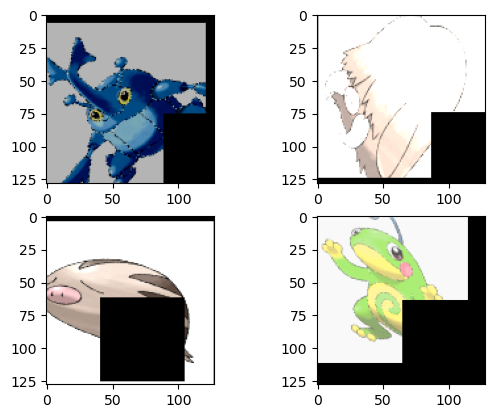

In [7]:
dataset = get_dataset(dataset_folder, image_size, batch_size)
for batch in dataset:
    for i in range(4):
        plt.subplot(2, 2, i+1)
        plt.imshow((DiffAugment((batch.numpy() + 1) / 2, policy='color,translation,cutout'))[i])
    break
plt.show()

## Training step

In [8]:
@tf.function
def train_step(images):
    seed = tf.random.normal([batch_size, latent_dim])
    images = DiffAugment(images, policy='color,translation,cutout')

    # train discriminator
    # pass real images to discriminator
    with tf.GradientTape() as disc_tape1:
        real_output = discriminator(images, training=True)
        real_targets = tf.ones_like(real_output) * 0.9
        disc_loss1 = binary_cross_entropy(real_targets, real_output)

    # apply gradients
    gradients_disc1 = disc_tape1.gradient(disc_loss1, discriminator.trainable_variables)
    disc_optimizer.apply_gradients(zip(gradients_disc1, discriminator.trainable_variables))

    # pass fake images to discriminator
    with tf.GradientTape() as disc_tape2:
        generated_images = generator(seed, training=True)
        generated_images = DiffAugment(generated_images, policy='color,translation,cutout')

        fake_output = discriminator(generated_images, training=True)
        fake_targets = tf.zeros_like(fake_output)
        disc_loss2 = binary_cross_entropy(fake_targets, fake_output)

    # apply gradients
    gradients_disc2 = disc_tape2.gradient(disc_loss2, discriminator.trainable_variables)
    disc_optimizer.apply_gradients(zip(gradients_disc2, discriminator.trainable_variables))

    # train generator
    with tf.GradientTape() as gen_tape:
        generated_images = generator(seed, training=True)
        generated_images = DiffAugment(generated_images, policy='color,translation,cutout')
        fake_output = discriminator(generated_images, training=True)
        real_targets = tf.ones_like(fake_output)
        gen_loss = binary_cross_entropy(real_targets, fake_output)

    # apply gradients
    gradients_gen = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gen_optimizer.apply_gradients(zip(gradients_gen, generator.trainable_variables))

    return disc_loss1 + disc_loss2, gen_loss

## Train GAN

In [9]:
dataset = get_dataset(dataset_folder, image_size, batch_size)

seed = tf.random.normal([25, latent_dim])
disc_losses = []
gen_losses = []

def train(dataset, epochs):
    generate_and_save_images(generator, 0, seed)
    for epoch in range(epochs):
        print(f'Training on epoch {epoch+1} (out of {epochs}).')
        for image_batch in dataset:
            losses = train_step(image_batch)
            disc_loss = losses[0]
            gen_loss = losses[1]
        
        gen_losses.append(gen_loss.numpy())
        disc_losses.append(disc_loss.numpy())

        if epoch % 50 == 0:
            generate_and_save_images(generator, epoch+1, seed)

    generate_and_save_images(generator, epochs, seed)
    discriminator.save(f'{trained_models_folder}/discriminator_epoch_{epochs}.h5')
    generator.save(f'{trained_models_folder}/generator_epoch_{epochs}.h5')

train(dataset, 200)

Found 1060 files belonging to 1 classes.


2024-04-07 08:10:01.414590: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-04-07 08:10:01.460821: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Training on epoch 1 (out of 200).
Training on epoch 2 (out of 200).
Training on epoch 3 (out of 200).
Training on epoch 4 (out of 200).
Training on epoch 5 (out of 200).
Training on epoch 6 (out of 200).
Training on epoch 7 (out of 200).
Training on epoch 8 (out of 200).
Training on epoch 9 (out of 200).
Training on epoch 10 (out of 200).
Training on epoch 11 (out of 200).
Training on epoch 12 (out of 200).
Training on epoch 13 (out of 200).
Training on epoch 14 (out of 200).
Training on epoch 15 (out of 200).
Training on epoch 16 (out of 200).
Training on epoch 17 (out of 200).
Training on epoch 18 (out of 200).
Training on epoch 19 (out of 200).
Training on epoch 20 (out of 200).
Training on epoch 21 (out of 200).
Training on epoch 22 (out of 200).
Training on epoch 23 (out of 200).
Training on epoch 24 (out of 200).
Training on epoch 25 (out of 200).
Training on epoch 26 (out of 200).
Training on epoch 27 (out of 200).
Training on epoch 28 (out of 200).
Training on epoch 29 (out of 

/opt/saturncloud/envs/saturn/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Save losses

In [11]:
import csv

zip_losses = list(zip(disc_losses, gen_losses))

headers = ['Discriminator Loss', 'Generator Loss']

with open('losses.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(headers)
    writer.writerows(zip_losses)